# Mapping Australia 2019/2020 fires
> An example of usage of BA-Net to map and date the extreme fire events that occured in eastern Australia in the fire season of 2019/2020.

## Defining region

In [ ]:
# local
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import matplotlib.pyplot as plt
from banet.geo import Region, open_shp
from banet.core import InOutPath

The viirs active fires data obtained at https://firms.modaps.eosdis.nasa.gov/download show be saved as `hotspots{region_name}.csv`. The content of this file looks like this:

In [ ]:
# local
path = InOutPath('/srv/australia2020/', 
                 '/srv/australia2020/')

# load and merge archive and nrt csv with VIIRS active fires
df1 = pd.read_csv(path.src/'fire_archive_V1_119718.csv')
df2 = pd.read_csv(path.src/'fire_nrt_V1_119718.csv')
df = pd.concat((df1, df2), axis=0, sort=True).reset_index(drop=True)

# select fires starting on September 2019
df = df.loc[df.acq_date>'2019-08-01'].reset_index(drop=True)

df.head()

,acq_date,acq_time,bright_ti4,bright_ti5,confidence,daynight,frp,instrument,latitude,longitude,satellite,scan,track,type,version
0,2019-08-02,406,325.3,284.9,n,NaN,3.0,VIIRS,-42.33496,147.25410,N,0.39,0.36,0.0,1
1,2019-08-02,406,328.9,283.8,n,NaN,2.0,VIIRS,-41.84022,147.70496,N,0.38,0.36,0.0,1
2,2019-08-02,406,345.1,291.3,n,NaN,7.2,VIIRS,-41.61977,148.19096,N,0.39,0.36,0.0,1
3,2019-08-02,406,328.2,281.0,n,NaN,2.1,VIIRS,-41.11841,147.84203,N,0.39,0.36,0.0,1
4,2019-08-02,407,331.7,289.7,n,NaN,2.3,VIIRS,-37.11568,149.87033,N,0.46,0.39,0.0,1


The scatter plot of active fires gives a general idea of the burned regions and can help to define the study region:

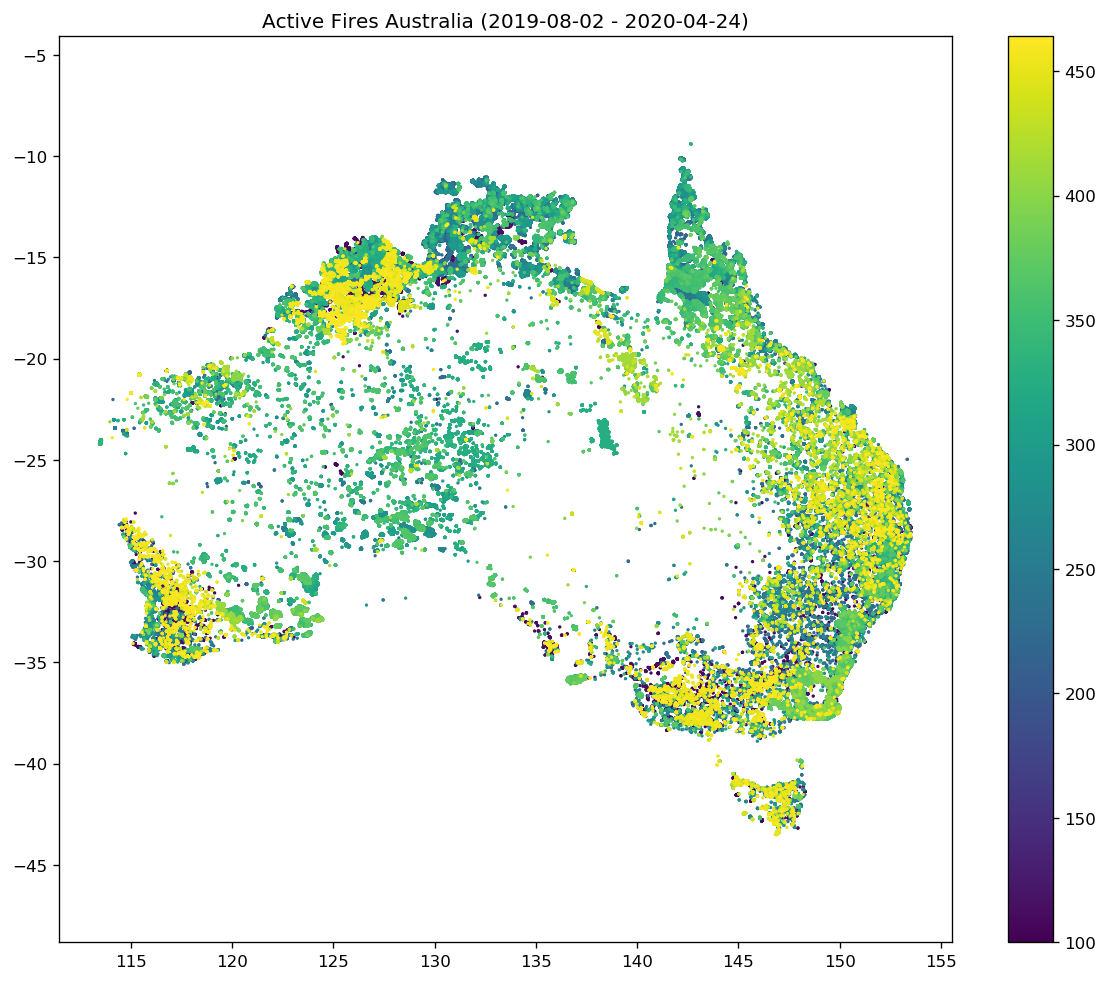

In [ ]:
# local
hour = df.acq_time.values//100
minute = df.acq_time.values-(df.acq_time.values//100)*100

times = pd.DatetimeIndex([pd.Timestamp(f'{o} {h}:{m}:00') 
         for o, h, m in zip(df.acq_date.values, hour, minute)])

doy = times.dayofyear.values
doy[doy<100] += 365 

df['doy'] = doy
df.sort_values('doy', inplace=True)

fig, ax = plt.subplots(figsize=(12,10), dpi=120, facecolor='w')
im = ax.scatter(df.longitude, df.latitude, s=1, c=df.doy)
ax.set_title(f'Active Fires Australia ({df.acq_date.min()} - {df.acq_date.max()})')
ax.axis('equal')
fig.colorbar(im, ax=ax);

In this case we are interested in looking to the fires in eastern Austrlia and the following region was selected (`[146, -39, 154, -26]`):

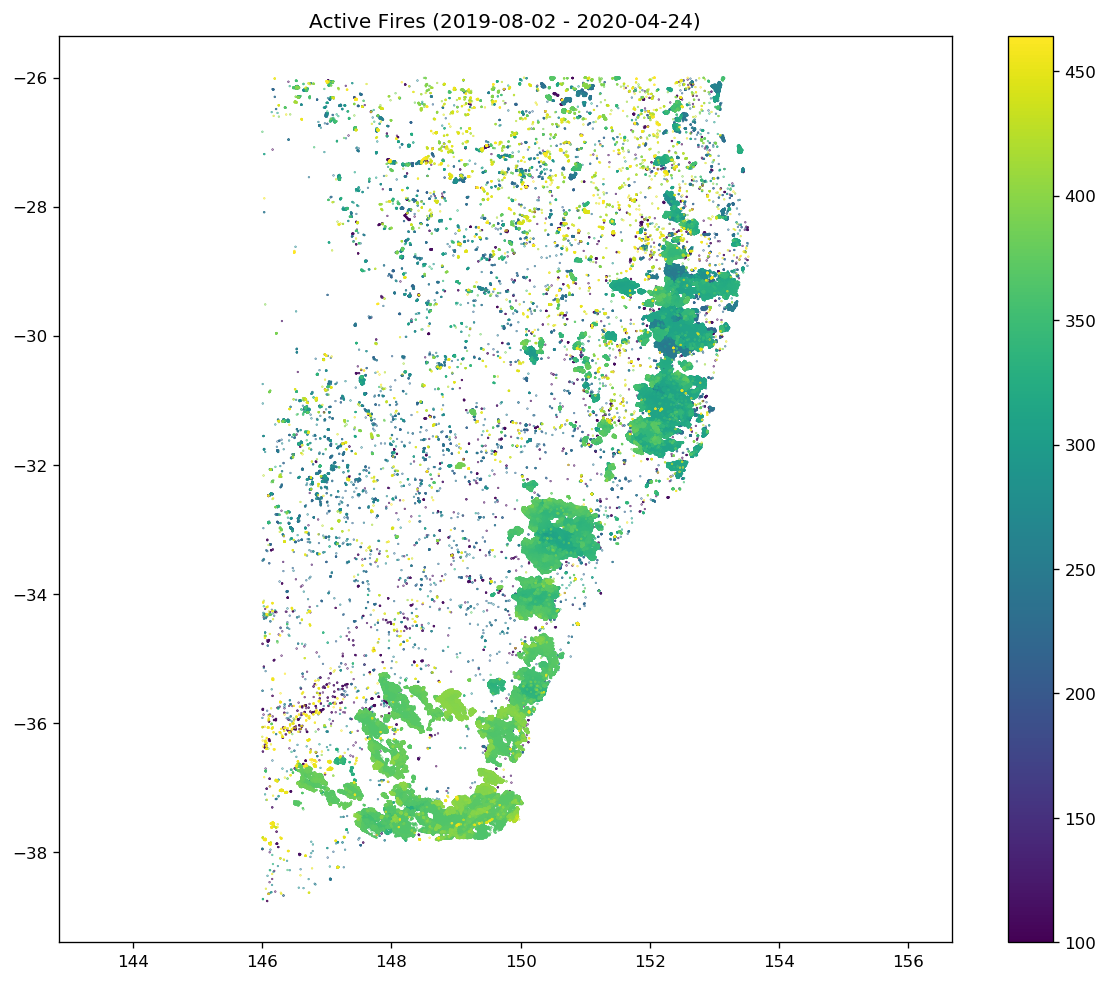

In [ ]:
# local
df_crop = df.loc[(df.longitude<154) & (df.longitude>146)
                 & (df.latitude<-26) & (df.latitude>-39)]

df_crop.to_csv(path.dst/'hotspotsAU2020.csv')

fig, ax = plt.subplots(figsize=(12,10), dpi=120, facecolor='w')
im = ax.scatter(df_crop.longitude, df_crop.latitude, s=.1, c=df_crop.doy)
ax.set_title(f'Active Fires ({df_crop.acq_date.min()} - {df_crop.acq_date.max()})')
ax.axis('equal')
fig.colorbar(im, ax=ax);

The `.json` file with the definition of the region can be saved as follows:

In [ ]:
# local
r = Region(name='AU2020', bbox=[146, -39, 154, -26], pixel_size=0.01)
r.export(path.dst/'R_AU2020.json')
print(f'Region shape: {r.shape}')

Region shape: (1300, 800)


## Downloading VIIRS data

The following bash script downloads the data for the defined time span:

```bash
#!/bin/bash -l 
region="AU2020"
tstart="2020-02-18 00:00:00"
tend="2020-03-31 23:59:59"
path_save="/srv/australia2020/rawdata"
regions_path="/srv/australia2020"

banet_viirs750_download $region "$tstart" "$tend" $path_save $regions_path
```

## Preprocess dataset

The following bash script can be used to preprocess the dataset:

```bash
#!/bin/bash -l
region="AU2020"
viirs_path="/srv/australia2020/rawdata"
save_path="/srv/australia2020/dataset"
fires_path="/srv/australia2020"
regions_path="/srv/australia2020"

banet_create_dataset $region $viirs_path $fires_path $save_path $regions_path
```

## Compute monthly burned areas product

Finally the following bash script used BA-Net to compute the burned areas for the given period. Notice that the product is not generated for the first and last months as BA-Net uses a time window of 64 days by default. For the following settings data will be produced for the period of 2019-09-01 to 2019-01-31.

```bash
#!/bin/bash -l
region="AU2020"
tstart="2019-08-01 00:00:00"
tend="2020-02-17 23:59:59"
input_path="/srv/australia2020/dataset"
output_path="/srv/australia2020/monthly"
regions_path="/srv/australia2020"

banet_predict_times $region "$tstart" "$tend" $input_path $output_path $regions_path
```

## Results

The following figures are examples of the results that can be produced from the output of BA-Net:

In [ ]:
# local
R = Region.load('/srv/australia2020/R_AU2020.json')
lon, lat = R.coords()
gdf = open_shp('/srv/australia2020/Australia_Polygon.shp')
data = sio.loadmat('/srv/australia2020/monthly/data.mat')
ba = data['burnconf']
I = ba>=0.5
bd = data['burndate']
bd[~I] = np.nan

/home/mnpinto/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater_equal
  import sys


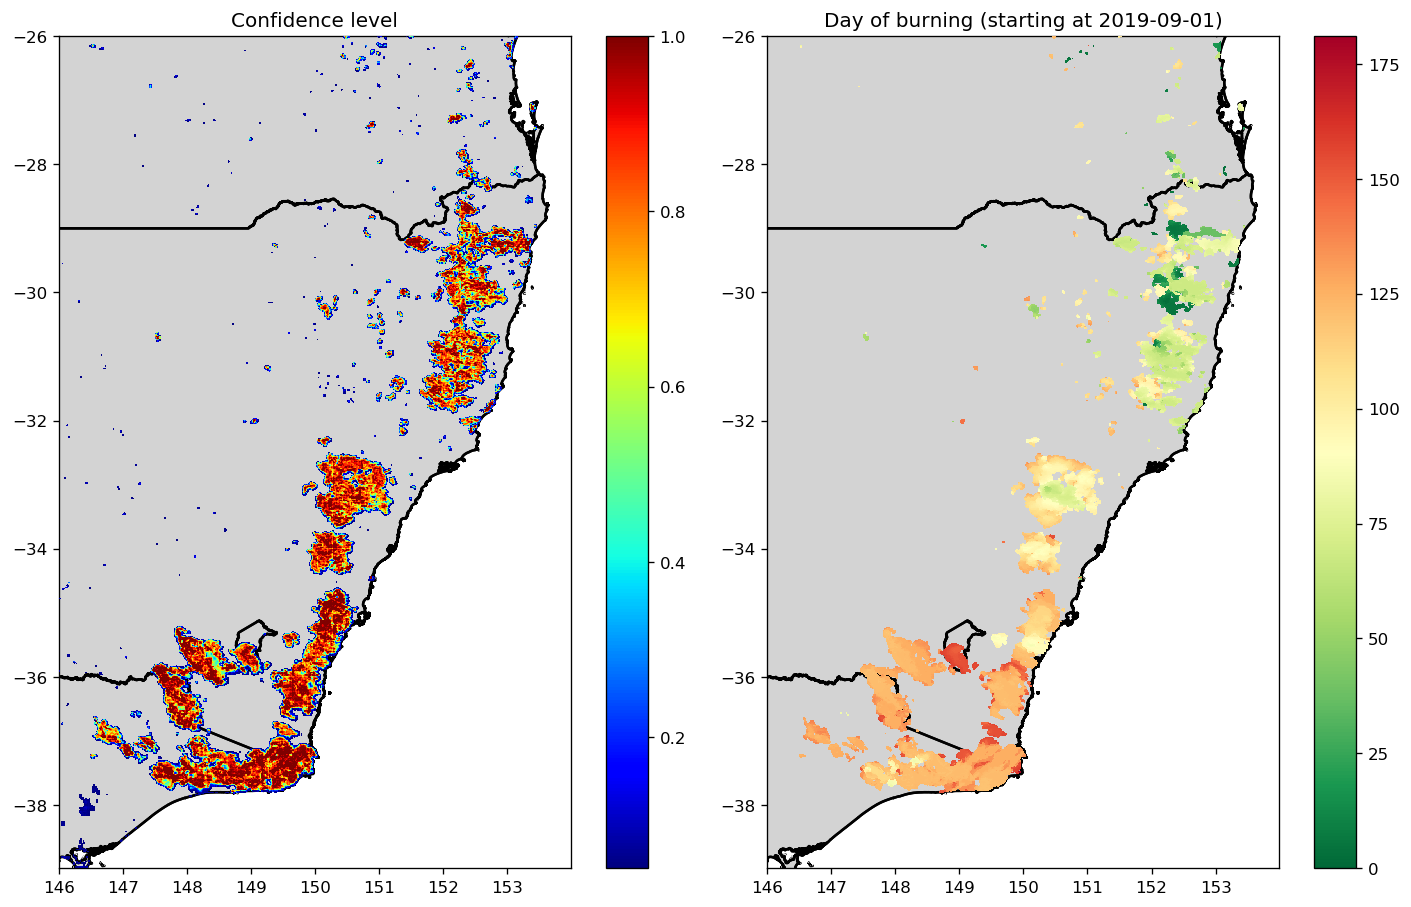

In [ ]:
# local
fig, axes = plt.subplots(ncols=2, figsize=(12,7.5), dpi=120, facecolor='w')
im0 = axes[0].pcolormesh(lon, lat, ba, cmap='jet', zorder=3)
im1 = axes[1].pcolormesh(lon, lat, bd, cmap='RdYlGn_r', zorder=3)
fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])
axes[0].set_title('Confidence level')
axes[1].set_title('Day of burning (starting at 2019-09-01)')
for ax in axes.flat:
    ax.axis('image')
    axis0 = ax.axis()
    gdf.plot(ax=ax, zorder=1, color='lightgray')
    gdf.boundary.plot(ax=ax, zorder=2, color='k')
    ax.axis(axis0)
fig.tight_layout();

/home/mnpinto/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


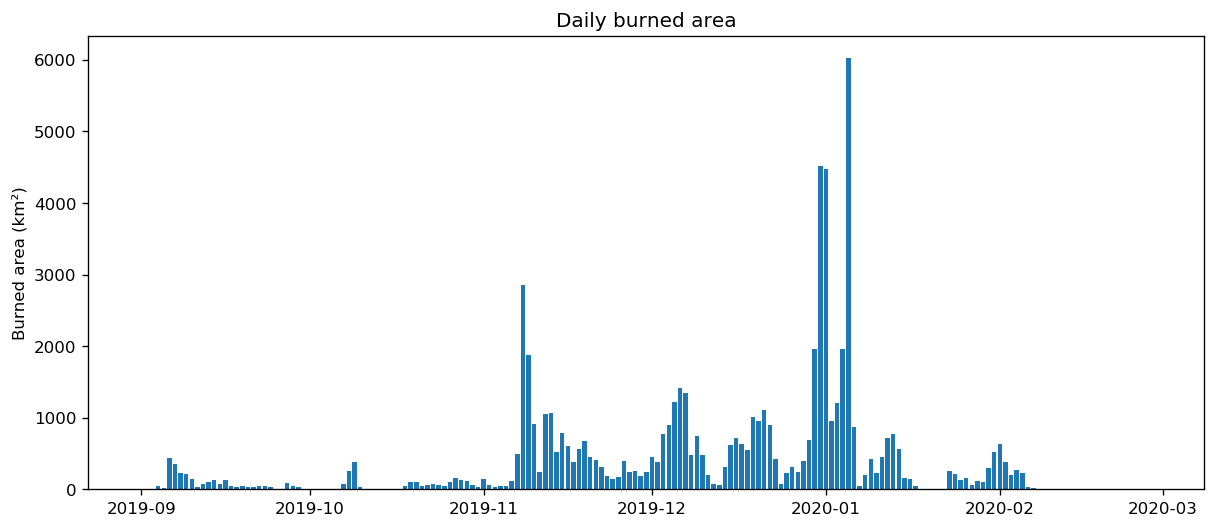

In [ ]:
# local
LON, LAT = np.meshgrid(lon, lat)
dLAT = 1.1111
dLON = dLAT*np.cos(np.deg2rad(LAT))
pix_size = dLON*dLAT

x = list(range(0, np.nanmax(bd).astype(int)))
times = pd.date_range('2019-09-01', '2020-03-31')[:len(x)]
y = [np.nansum(pix_size[bd==i]) for i in x]
df = pd.DataFrame({'times': pd.DatetimeIndex(times), 'freq': y})

fig, ax = plt.subplots(figsize=(12,5), dpi=120, facecolor='w')
ax.bar(df.times,df.freq)
ax.set_ylabel('Burned area (km²)')
ax.set_title('Daily burned area');

Text(0.5, 1.0, 'Monthly burned area (2019-09 to 2020-01)')

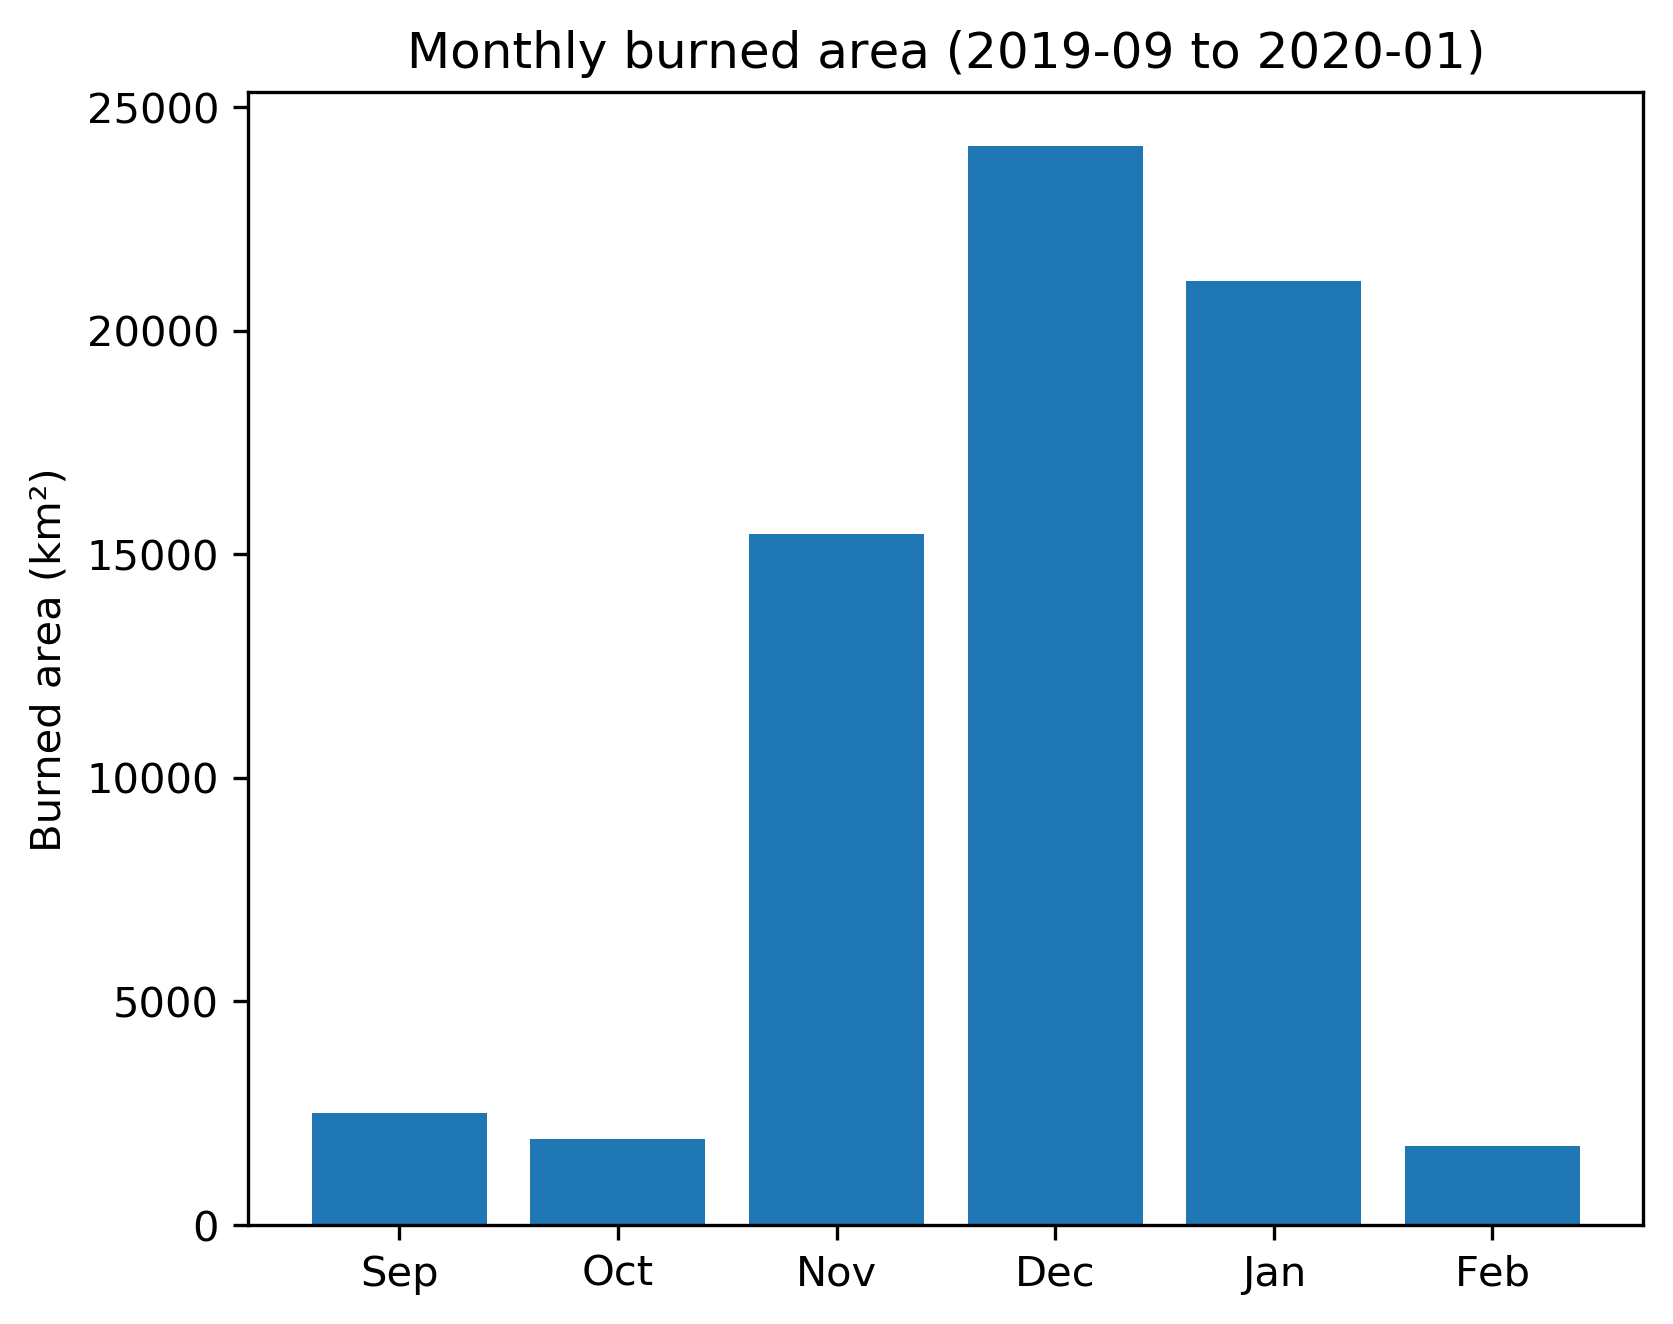

In [ ]:
# local
df['month'] = df.times.dt.month

monthly = df.groupby('month').sum().reset_index()

mnames = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly['month'] = mnames[monthly.month.values-1]

monthly = monthly.iloc[[2,3,4,5,0,1]]

fig, ax = plt.subplots(figsize=(6,5), dpi=300, facecolor='w')
ax.bar(monthly.month, monthly.freq)
ax.set_ylabel('Burned area (km²)')
ax.set_title('Monthly burned area (2019-09 to 2020-01)')

In [ ]:
# local
print(f'Total burned area: {np.round(np.nansum(df.freq)*100)} ha')

Total burned area: 6688147.0 ha
